In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [2]:
import os
import sys
dir_path = '/content/gdrive/My Drive/myurbcomp/assignment_1'
sys.path.append(dir_path)

In [3]:
# some modules that need to be installed
!pip install geopandas==0.8.1 matplotlib==3.2.2 networkx==2.3  numpy==1.18.5  pandas==1.0.5  seaborn==0.10.1

In [4]:
# including modules
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import datetime 
import seaborn as sns
import operator
import numpy as np
import geopandas as gp
%load_ext autoreload
%autoreload 2
from utils import airtraffic_helpers
import networkx as nx
import community
import random
from shapely.geometry import Point

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [58]:
# Dometics airport details
airports_df = pd.read_csv("{}/dataset/288804893_T_MASTER_CORD.csv".format(dir_path))
print('Shape of the dataframe:',airports_df.shape,'\n')
print('Printing one record:',airports_df[:1].T)

Shape of the dataframe: (18101, 28) 

Printing one record:                                                    0
AIRPORT_ID                                     10001
AIRPORT                                          01A
DISPLAY_AIRPORT_NAME            Afognak Lake Airport
DISPLAY_AIRPORT_CITY_NAME_FULL      Afognak Lake, AK
AIRPORT_WAC                                        1
AIRPORT_COUNTRY_NAME                   United States
AIRPORT_COUNTRY_CODE_ISO                          US
AIRPORT_STATE_NAME                            Alaska
AIRPORT_STATE_CODE                                AK
AIRPORT_STATE_FIPS                                 2
CITY_MARKET_ID                                 30001
DISPLAY_CITY_MARKET_NAME_FULL       Afognak Lake, AK
CITY_MARKET_WAC                                    1
LAT_DEGREES                                       58
LAT_HEMISPHERE                                     N
LAT_MINUTES                                        6
LAT_SECONDS                             

In [59]:
# Dometics airlines connections
trips_df = pd.read_csv("{}/dataset/288798530_T_T100D_MARKET_ALL_CARRIER.csv".format(dir_path))
print('Shape of the dataframe:',trips_df.shape,'\n')
print('Printing one record:',trips_df[:1].T)

Shape of the dataframe: (41930, 8) 

Printing one record:                                       0
UNIQUE_CARRIER                      04Q
UNIQUE_CARRIER_NAME  Tradewind Aviation
ORIGIN_AIRPORT_ID                 13535
ORIGIN                              MVL
DEST_AIRPORT_ID                   12197
DEST                                HPN
MONTH                                 1
Unnamed: 7                          NaN


In [7]:
# Extracting edges - we consider a connection from one airport to another as an edge.
# Note: these edges will be directed.
edges = list(zip(trips_df['ORIGIN_AIRPORT_ID'],trips_df['DEST_AIRPORT_ID']))

In [9]:
# creating directed and undirected graphs based on airports and their connections
G = nx.DiGraph()
G.add_edges_from(edges)
G_undirected = nx.Graph()
G_undirected.add_edges_from(edges)

In [10]:
# printing the total number of nodes and edges of directed graph
print('Total number of airports:',len(list(G.nodes)))
print('Total number of connections:',len(list(G.edges)))

Total number of airports: 894
Total number of connections: 13760


In [11]:
# creating a GeoDataframe for plotting airports on a map
airport_ids = list(G.nodes)
edgelist = list(G.edges)
geo_stations = airtraffic_helpers.get_geodataframe_airports(airports_df,airport_ids)

/usr/local/lib/python3.6/dist-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


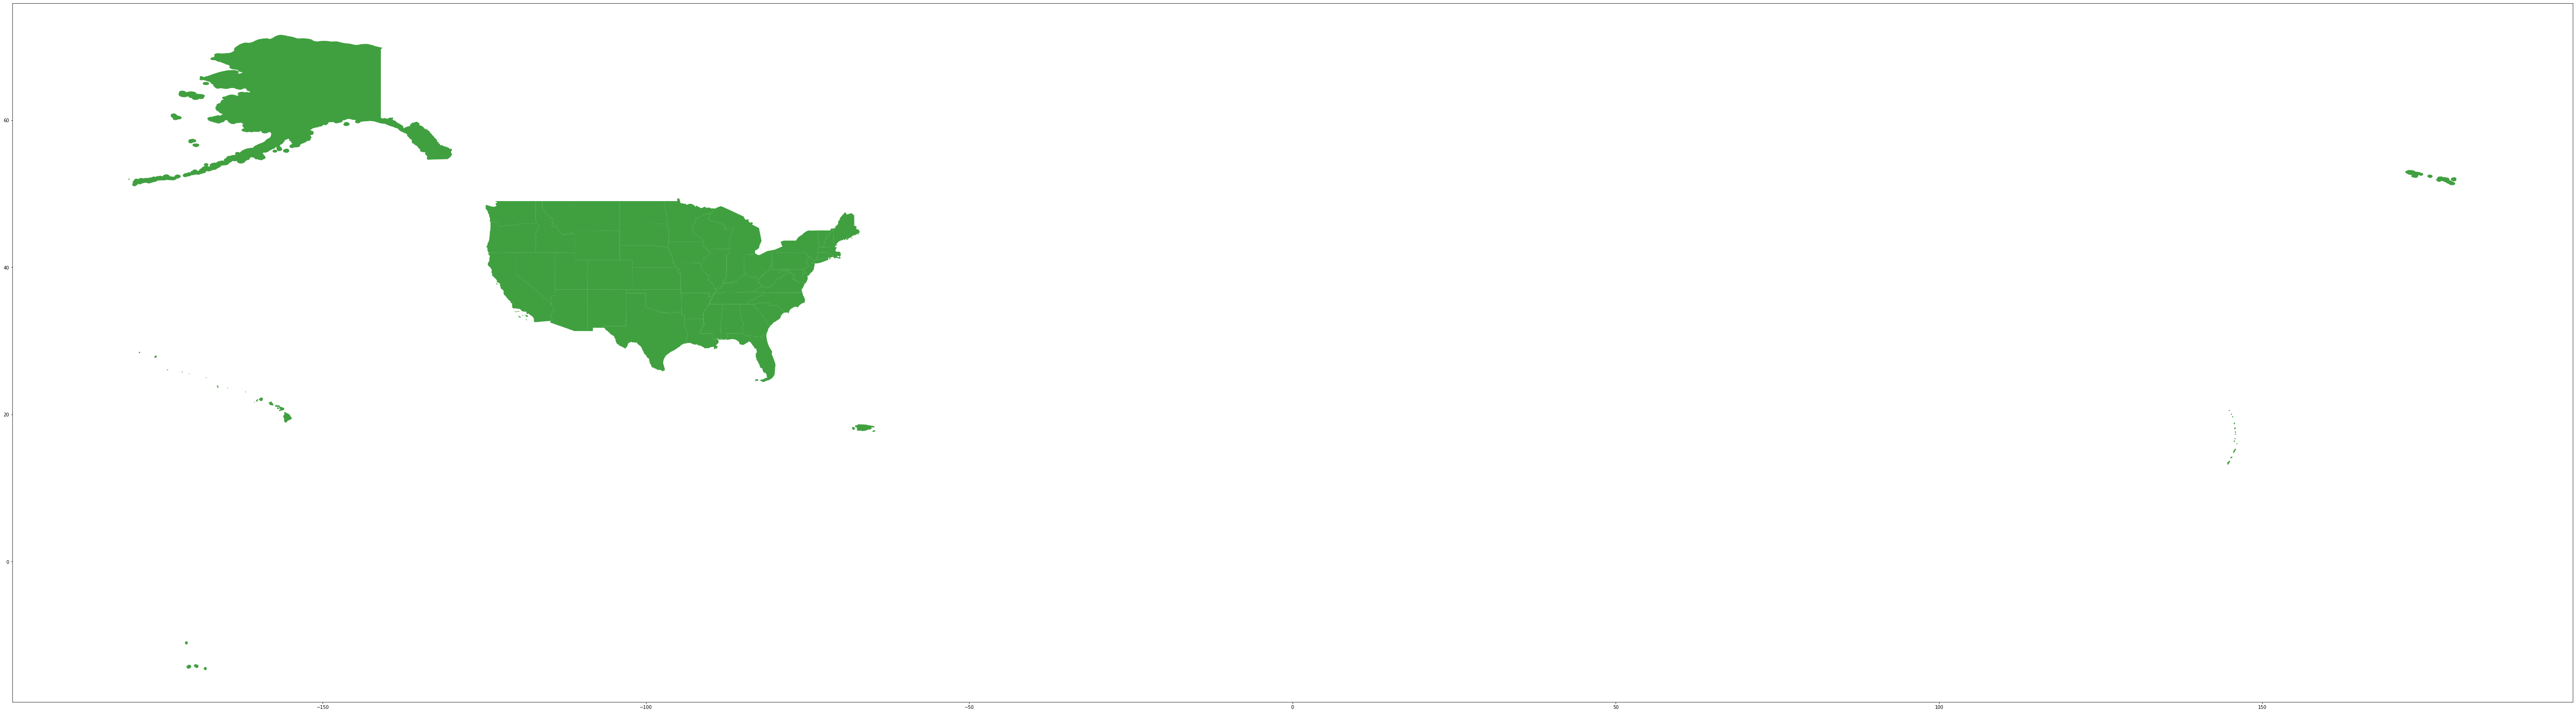

In [62]:
# reading the shape file of US
shp_us = gp.GeoDataFrame.from_file("{}/dataset/Igismap/Alabama_AL4_US_Poly.shp".format(dir_path))
shp_us=shp_us.to_crs({'init':'epsg:4326'})
shp_us.plot(figsize=(100,100),color='g',alpha=0.75)

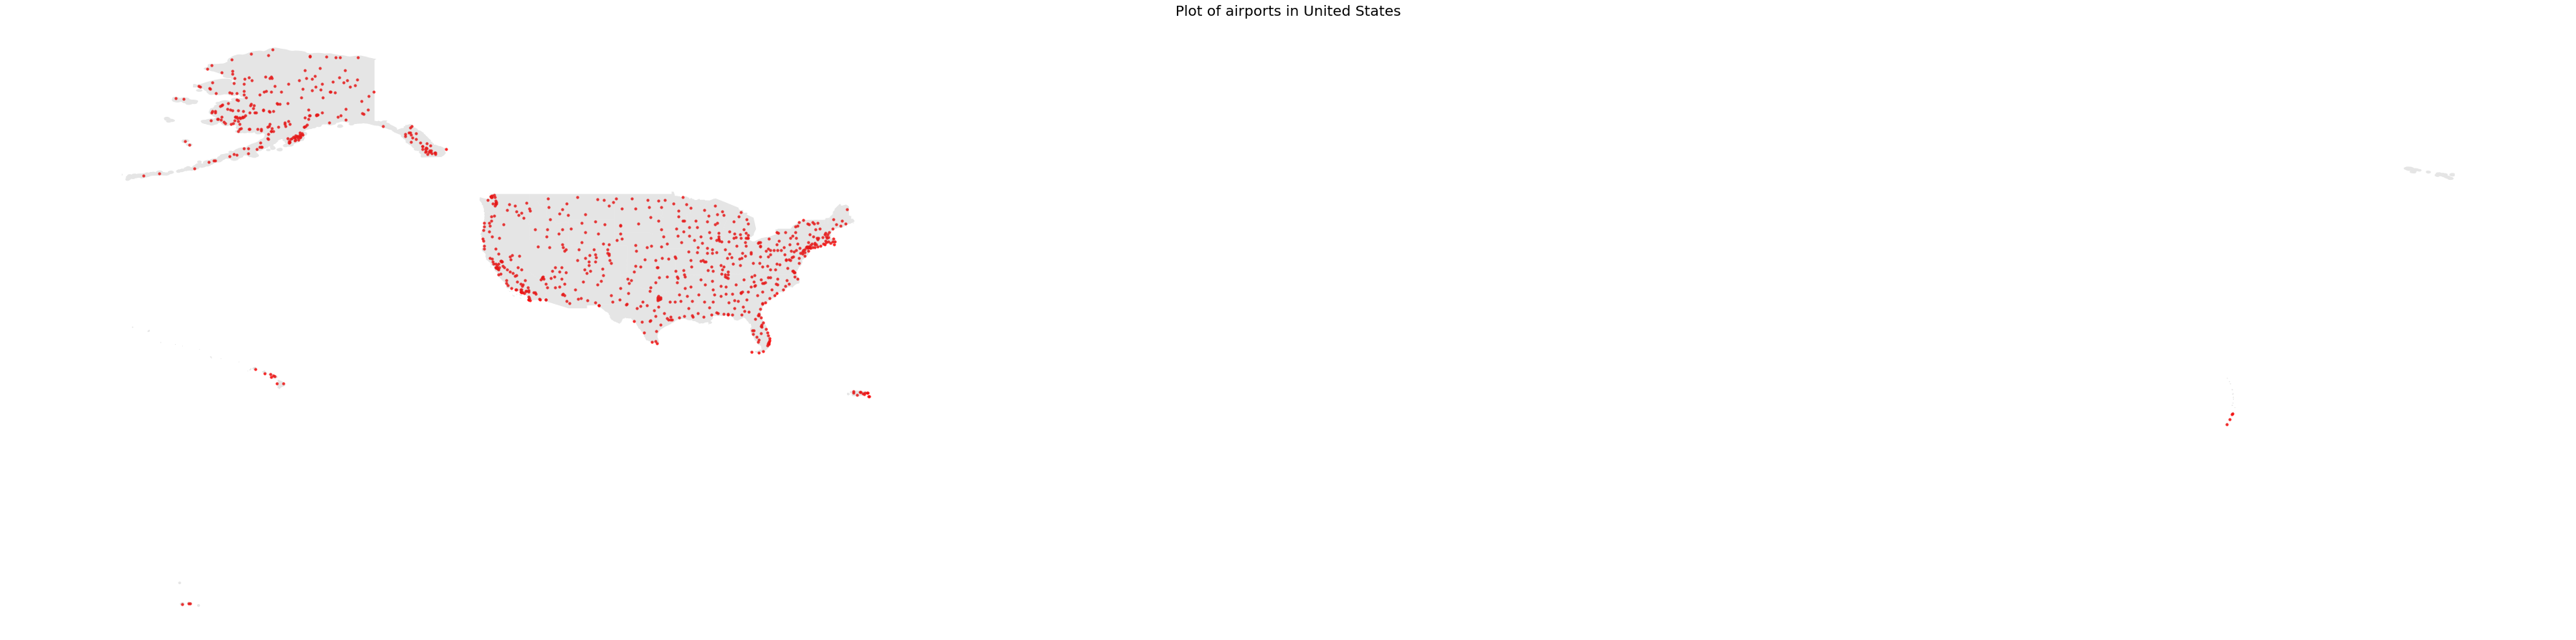

In [63]:
# plotting the nodes in the shape file of US
plt.style.use("default")
%matplotlib inline
fig, ax = plt.subplots(1,1,figsize=(50,50))
base = shp_us.plot(ax=ax, color='gray', alpha=0.2)
geo_stations.plot(ax=base, marker="o", color="r", markersize=10,alpha=0.8, zorder=0)
_ = ax.axis('off')
ax.set_title("Plot of airports in United States",fontsize=20)
fig.tight_layout()
fig.savefig("{}/figures/us_airports_nodes.pdf".format(dir_path))

In [52]:
# displaying the network based on actual geographical placement of nodes
position_dict = {} # will contain the node coordinates 
for item in list(geo_stations.station_ids):
  position_dict[item] = geo_stations[geo_stations.station_ids==item].geometry.values[0].x,geo_stations[geo_stations.station_ids==item].geometry.values[0].y
fig, ax = plt.subplots(1,1,figsize=(100,40))
nx.draw(G,pos=position_dict)
fig.tight_layout()
fig.savefig("{}/figures/us_airports_network_withposition.pdf".format(dir_path))

Output hidden; open in https://colab.research.google.com to view.

/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:676: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if cb.iterable(node_size):  # many node sizes


1


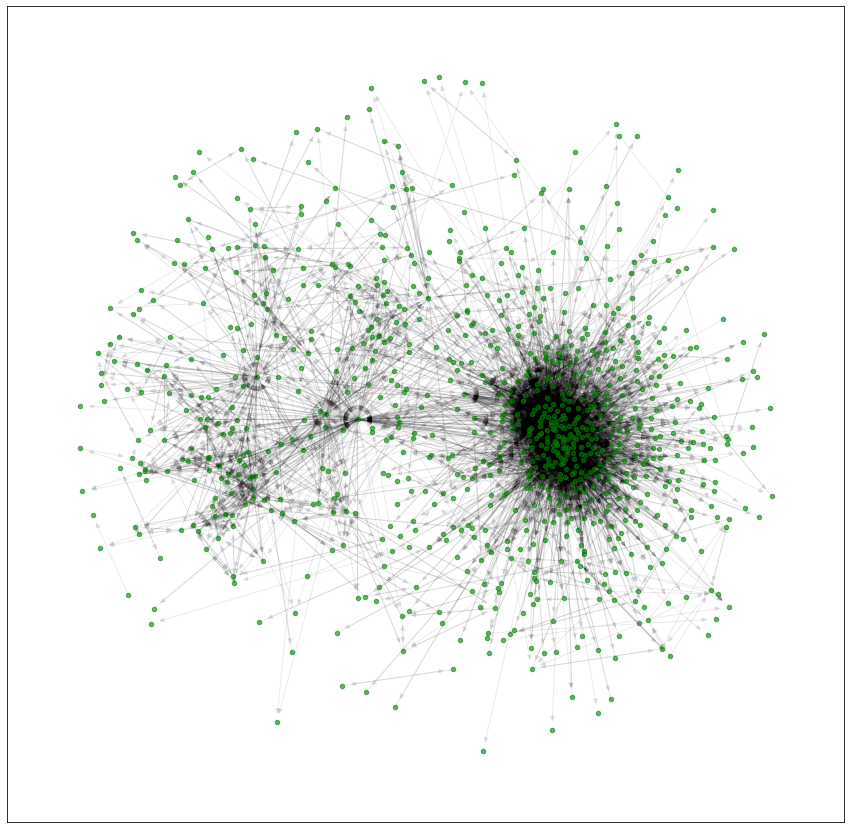

In [54]:
# displaying the network with optimal placement of nodes
airtraffic_helpers.plot_network(G,title="",edgealpha=0.08,node_dist=1,nodesize=20,savefig=False,figsize=(15,15))

## Strongly And Weakly Connected Components

Number of Strongly Connected Components 47 
Sample Strongly Connected Components [[12222], [12583], [11487]]


Text(0, 0.5, 'Number of Nodes Per Component')

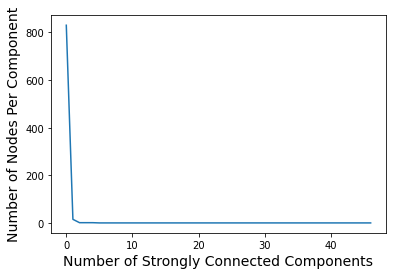

In [16]:
#Strongly Connected Components    
scc=[list(l) for l in nx.strongly_connected_components(G)]  #Strongly Connected Components
print("Number of Strongly Connected Components",len(scc),"\nSample Strongly Connected Components",scc[:3])
plt.plot(list(sorted(map(lambda x: len(x),scc),reverse=True)))
plt.xlabel("Number of Strongly Connected Components",fontsize=14)
plt.ylabel("Number of Nodes Per Component",fontsize=14)

Number of Weakly Connected Components 6 
Sample Weakly Connected Components [[10241, 10243, 10245, 16390, 10247, 12294, 10257, 12315, 10268, 10272, 12321, 12323, 12324, 10275, 10278, 10279, 12335, 12339, 12343, 10298, 10299, 12348, 10304, 10313, 12363, 12365, 10322, 12370, 10325, 10327, 12375, 10329, 14424, 10333, 12391, 10347, 10348, 12397, 10349, 12402, 14457, 10361, 12412, 14467, 10372, 10374, 14470, 14474, 14477, 12436, 14485, 14487, 14488, 12441, 14489, 14492, 10397, 10396, 14493, 12448, 12451, 10405, 12455, 10408, 10409, 10414, 14512, 10416, 10419, 16566, 10423, 14520, 16567, 14524, 12478, 10431, 14530, 10434, 14533, 14534, 14539, 12492, 14543, 14551, 16603, 12511, 14559, 10466, 10469, 12519, 10472, 14570, 12523, 14572, 14574, 10478, 14576, 14582, 14588, 12544, 12545, 16647, 12553, 12559, 10511, 10519, 16668, 12574, 12576, 10529, 14627, 12583, 10535, 14633, 14635, 10540, 12587, 12598, 10551, 14648, 10556, 10557, 10558, 10559, 10561, 10562, 12610, 12615, 10572, 12621, 14672, 10577

Text(0, 0.5, 'Number of Nodes Per Component')

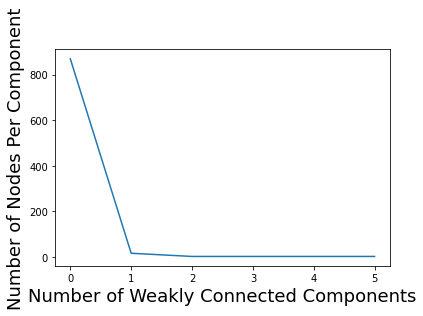

In [17]:
# Weakly Connected Components
wcc=[list(l) for l in nx.weakly_connected_components(G)]  #Strongly Connected Components
print("Number of Weakly Connected Components",len(wcc),"\nSample Weakly Connected Components",wcc[:3])
plt.plot(list(sorted(map(lambda x: len(x),wcc),reverse=True)))
plt.xlabel("Number of Weakly Connected Components",fontsize=18)
plt.ylabel("Number of Nodes Per Component",fontsize=18)

## Plot Degree Distribution

In [21]:
# node degree calculation
node_indegrees=[item for item in dict(G.in_degree()).items()]
node_outdegrees=[item for item in dict(G.out_degree()).items()]
sorted_indegrees=sorted(node_indegrees,key=operator.itemgetter(1),reverse=True)
sorted_outdegrees=sorted(node_outdegrees,key=operator.itemgetter(1),reverse=True)

print("Sample Indegree List",node_indegrees[:5],"\n")
print("Sorted In Decreasing Order of Indegrees",sorted_indegrees[:5],"\n")
print("Sample Outdegree List",node_outdegrees[:5],"\n")
print("Sorted In Decreasing Order of Outdegree",sorted_outdegrees[:5],"\n")

node_degrees=airtraffic_helpers.getdegree(G)
print("Sample degree list",node_degrees[:5],"\n")
sorted_degrees=sorted(node_degrees,key=operator.itemgetter(1),reverse=True)
print("Sorted in decreasing order of degrees",sorted_degrees[:5],"\n")

Sample Indegree List [(13535, 5), (12197, 58), (10792, 65), (10540, 39), (13303, 101)] 

Sorted In Decreasing Order of Indegrees [(11292, 192), (11298, 192), (13930, 183), (10397, 174), (13244, 154)] 

Sample Outdegree List [(13535, 2), (12197, 60), (10792, 61), (10540, 39), (13303, 103)] 

Sorted In Decreasing Order of Outdegree [(11292, 191), (11298, 191), (13930, 188), (10397, 177), (13244, 148)] 

Sample degree list [(13535, 7), (12197, 118), (10792, 126), (10540, 78), (13303, 204)] 

Sorted in decreasing order of degrees [(11292, 383), (11298, 383), (13930, 371), (10397, 351), (13244, 302)] 



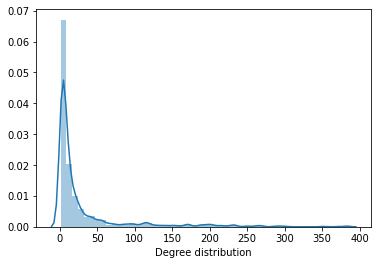

In [22]:
# plotting the degree distribution
sns.distplot(pd.Series(np.array(node_degrees).T[1], name="Degree distribution"))

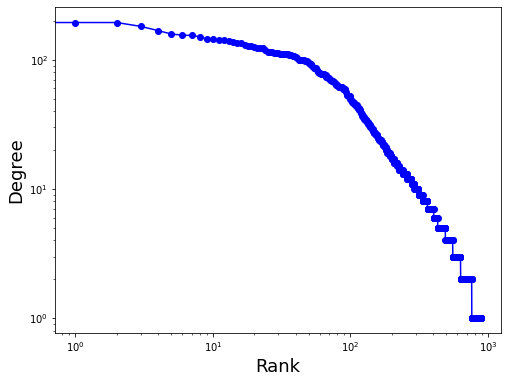

In [23]:
# plotting the degree-rank plot
airtraffic_helpers.generate_degree_rank_plot(edgelist)

# Network density, Connected Components, diameter and shortest paths.

In [24]:
# find network density
print('Network density:',nx.density(G))

Network density: 0.017235721031838486


In [25]:
sub_graphs = [G_undirected.subgraph(c).copy() for c in nx.connected_components(G_undirected)]
print('Number of connected components: ',len([k for k in sub_graphs]))

Number of connected components:  6


In [26]:
# finding and plotting the giant connected component
Gc = max(sub_graphs, key=len)
Gc=nx.convert_node_labels_to_integers(Gc)
Gc.name='GCC'
print(nx.info(Gc))
print('Diameter of the Giant connected component:',nx.diameter(Gc))
print('Average shortest path:',nx.average_shortest_path_length(Gc))

Name: GCC
Type: Graph
Number of nodes: 870
Number of edges: 8097
Average degree:  18.6138
Diameter of the Giant connected component: 10
Average shortest path: 3.1862068965517243


/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


1


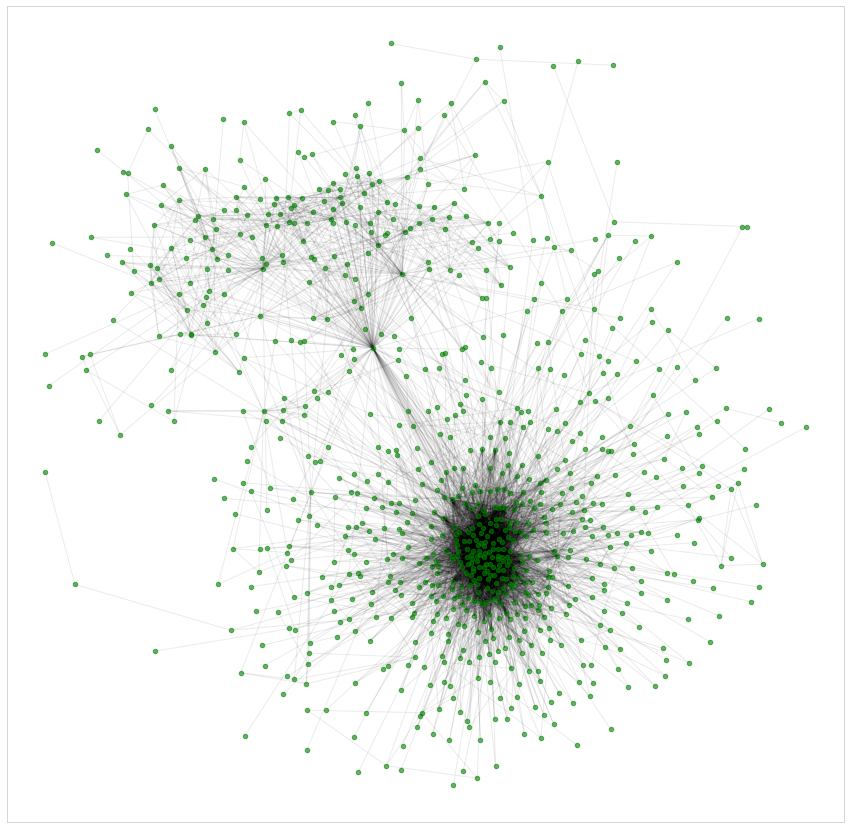

In [48]:
# plotting the GCC
airtraffic_helpers.plot_network(Gc,title="",edgealpha=0.08,node_dist=1,nodesize=20,savefig=False,figsize=(15,15))

## Centrality measures

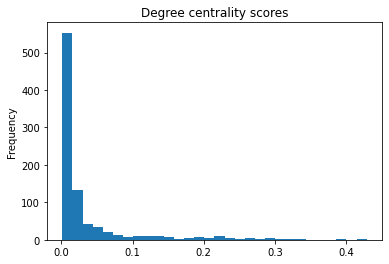

In [28]:
pd.Series(nx.degree_centrality(G)).sort_values().plot(kind='hist',bins=30,title="Degree centrality scores")

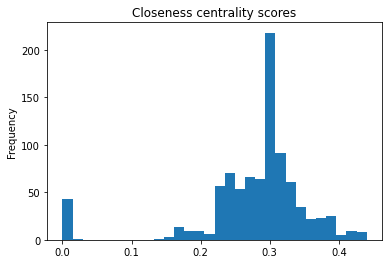

In [29]:
pd.Series(nx.closeness_centrality(G)).sort_values().plot(kind='hist',bins=30,title="Closeness centrality scores")

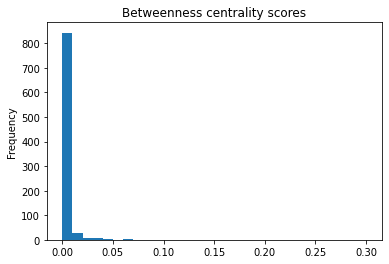

In [30]:
pd.Series(nx.betweenness_centrality(G)).sort_values().plot(kind='hist',bins=30,title="Betweenness centrality scores")

# Clustering coefficient

Average Clustering Coefficient 0.5151


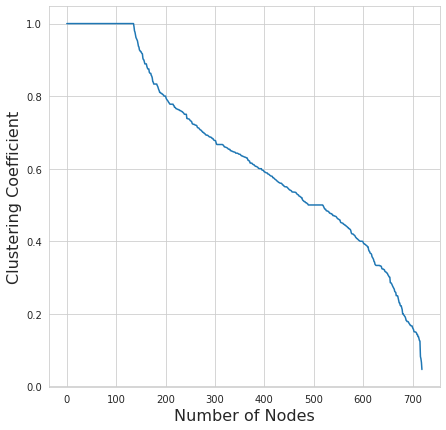

In [31]:
# plotting average clustering coefficient
airtraffic_helpers.generate_clustering_coefficient_plot(G)
clust_coeff=nx.average_clustering(G)
print("Average Clustering Coefficient",round(clust_coeff,4))

# Node Centric Community Detection

In [32]:
# As the network is large, we will randomly select 400 nodes for node centric community detection analysis
airportids_subset = random.sample(airport_ids,k=300)

In [33]:
# filter edges to contain nodes only from the above generated airports subset
edgelist_subset = []
for item in edgelist:
  if item[0] in airportids_subset and item[1] in airportids_subset:
    edgelist_subset.append(item)

In [34]:
G_subset_undirected = nx.Graph()
G_subset_undirected.add_edges_from(edgelist_subset)

In [35]:
# identifying the cliques in the network
cl=nx.enumerate_all_cliques(G_subset_undirected)
#print last 10 cliques
print([l for l in cl][-10:])

[[14100, 14635, 13930, 13495, 12892, 12266, 12478, 14831, 10423, 13796, 14570, 10140], [14100, 14635, 13930, 13495, 12892, 12266, 12478, 10423, 14893, 13796, 14570, 10140], [11697, 14635, 12339, 13930, 13495, 12892, 12266, 12478, 14831, 10423, 13796, 14570], [11697, 14635, 12339, 13930, 13495, 12892, 12266, 12478, 10423, 14893, 13796, 14570], [11697, 14635, 13930, 13495, 12892, 12266, 12478, 14831, 10423, 13796, 14570, 10140], [11697, 14635, 13930, 13495, 12892, 12266, 12478, 10423, 14893, 13796, 14570, 10140], [14100, 11697, 14635, 12339, 13930, 13495, 12892, 12266, 12478, 14831, 10423, 13796, 14570], [14100, 11697, 14635, 12339, 13930, 13495, 12892, 12266, 12478, 10423, 14893, 13796, 14570], [14100, 11697, 14635, 13930, 13495, 12892, 12266, 12478, 14831, 10423, 13796, 14570, 10140], [14100, 11697, 14635, 13930, 13495, 12892, 12266, 12478, 10423, 14893, 13796, 14570, 10140]]


In [36]:
# printing the 5 largest cliques
print("5 Largest Cliques",sorted([l for l in nx.find_cliques(G_subset_undirected)],key=lambda x: len(x),reverse=True)[:5])

5 Largest Cliques [[13930, 14100, 11697, 12339, 13796, 13495, 10423, 12892, 12266, 14635, 14570, 12478, 14893], [13930, 14100, 11697, 12339, 13796, 13495, 10423, 12892, 12266, 14635, 14570, 12478, 14831], [13930, 14100, 11697, 10140, 13495, 12892, 13796, 10423, 12266, 14635, 14570, 12478, 14893], [13930, 14100, 11697, 10140, 13495, 12892, 13796, 10423, 12266, 14635, 14570, 12478, 14831], [13930, 14100, 11697, 12339, 13796, 13495, 10423, 12892, 11259, 14570, 14635, 14893]]


In [39]:
# printing cliques containing Node ID 14107
print(nx.cliques_containing_node(G_subset_undirected,13495))

[[13930, 14100, 11697, 12992, 13796, 14635, 14831, 13495, 12892, 10423, 12266], [13930, 14100, 11697, 12992, 13796, 14635, 14831, 13495, 12892, 10423, 11259], [13930, 14100, 11697, 14321, 14635, 13931, 10140, 13495, 11259], [13930, 14100, 11697, 14321, 14635, 13931, 10140, 13495, 12478], [13930, 14100, 11697, 14321, 14524, 13931, 13495, 11259], [13930, 14100, 11697, 14321, 14524, 13931, 13495, 12478], [13930, 14100, 11697, 12339, 13796, 13495, 14524, 12266, 11996], [13930, 14100, 11697, 12339, 13796, 13495, 14524, 12266, 12478, 12892], [13930, 14100, 11697, 12339, 13796, 13495, 14524, 11259, 11996], [13930, 14100, 11697, 12339, 13796, 13495, 14524, 11259, 12892], [13930, 14100, 11697, 12339, 13796, 13495, 10423, 11996, 14635, 12266], [13930, 14100, 11697, 12339, 13796, 13495, 10423, 11996, 14635, 11259], [13930, 14100, 11697, 12339, 13796, 13495, 10423, 12892, 12266, 14635, 11986], [13930, 14100, 11697, 12339, 13796, 13495, 10423, 12892, 12266, 14635, 14570, 12478, 14893], [13930, 1410

In [40]:
# Find K cliques using percolation method. K=10
print([l for l in nx.algorithms.community.k_clique_communities(G_subset_undirected,10)])

[frozenset({12992, 11986, 14100, 10713, 10140, 12892, 11996, 12191, 13796, 10599, 13930, 12266, 14570, 14893, 13931, 14635, 14831, 11697, 11884, 12339, 13303, 12278, 10423, 13495, 11259, 14524, 12478})]


/usr/local/lib/python3.6/dist-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):


1


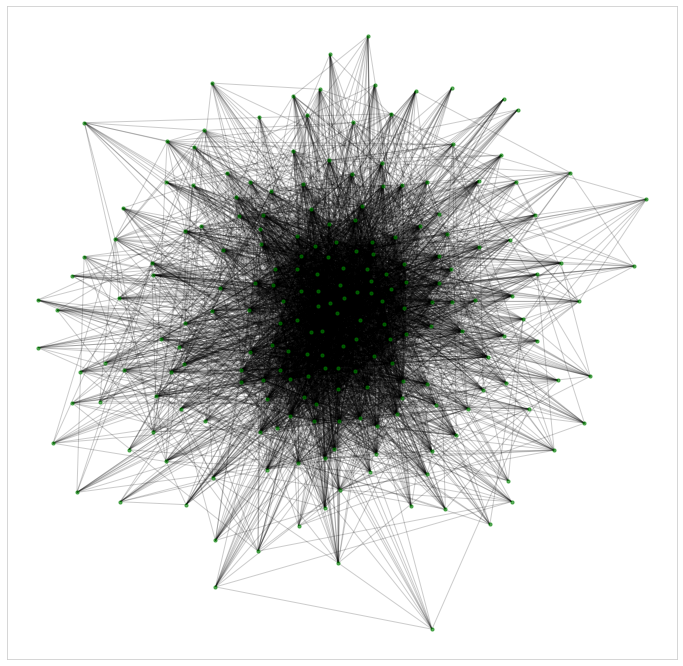

In [41]:
# finding k-core, in this case k=12
G_noselfloop = G_undirected
G_noselfloop.remove_edges_from(nx.selfloop_edges(G_noselfloop))
g_k=nx.k_core(G_noselfloop,k=12)
airtraffic_helpers.plot_network(g_k,node_dist=4,figsize=(12,12),nodesize=10)

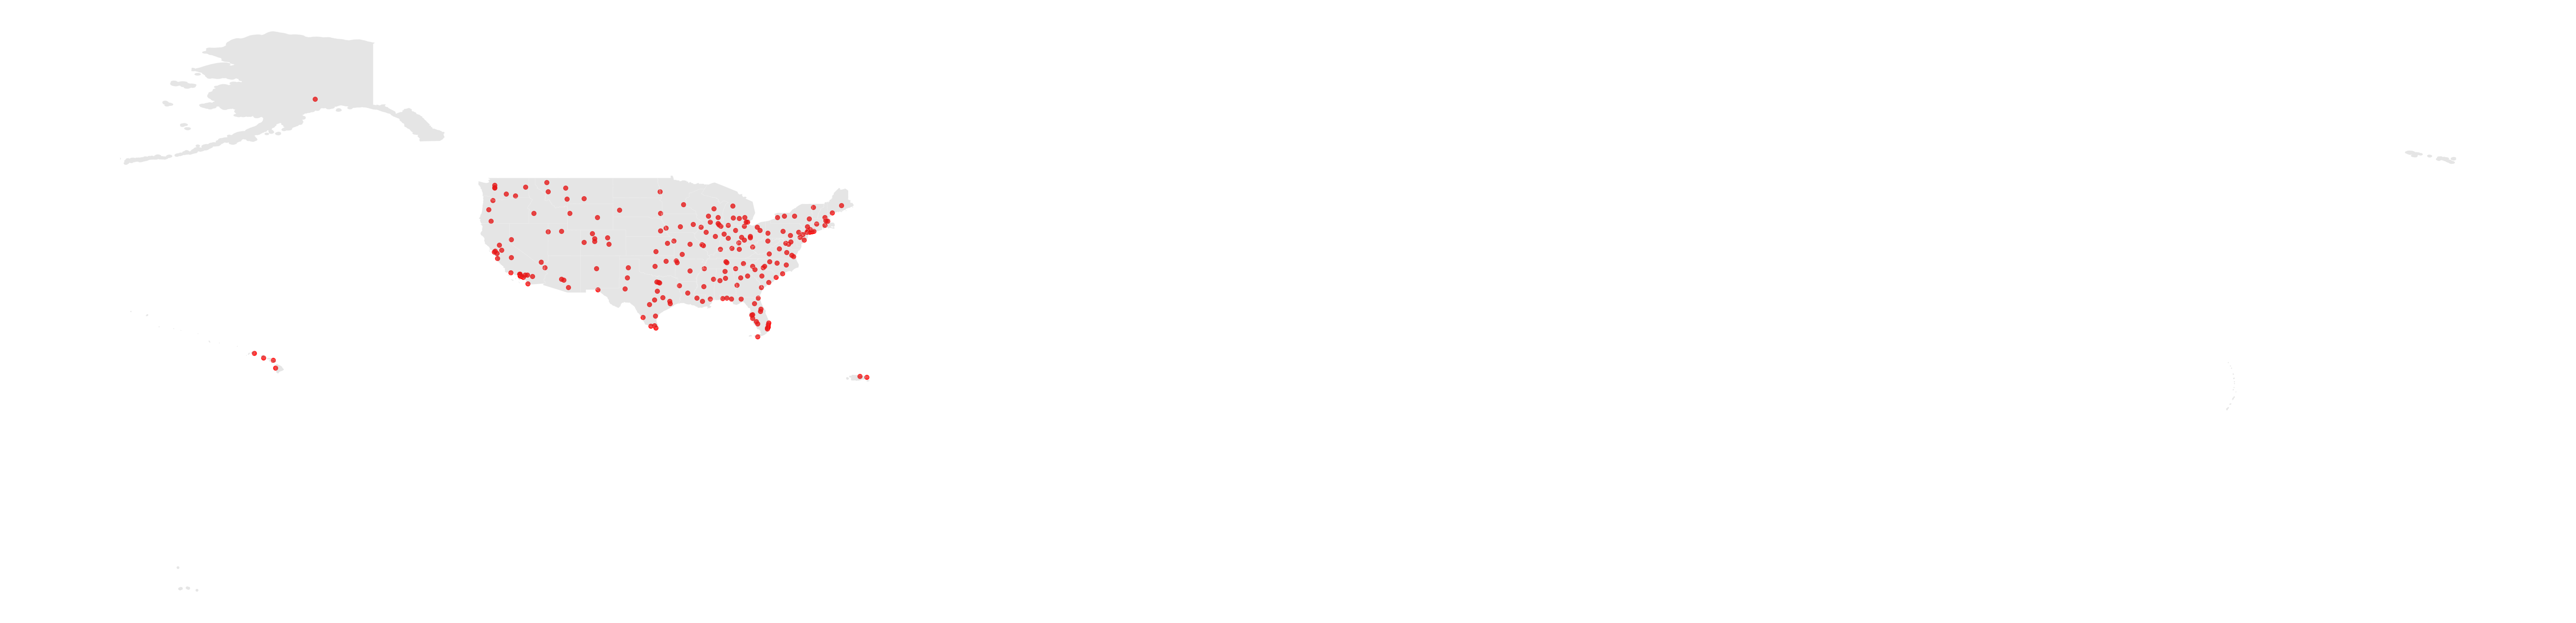

In [42]:
#Code to generate the shape file and station k_core visualization.
labels=g_k.nodes()
fig, ax = plt.subplots(1,1,figsize=(100,40))
base = shp_us.plot(ax=ax, color='gray', alpha=0.2)
geo_stations[geo_stations.station_ids.isin(labels)].plot(ax=base, marker="o", color="r", markersize=100,alpha=0.8, zorder=0)
_ = ax.axis('off')

# PAGERANK

In [43]:
pg_rank=sorted([l for l in nx.pagerank(G).items()],key=lambda x: x[1],reverse=True)
print("Top 10 Stations By Pagerank",pg_rank[:10])

Top 10 Stations By Pagerank [(11292, 0.012214947254762685), (11298, 0.011381590445025944), (13930, 0.009979623124020178), (10299, 0.009395117074679805), (10397, 0.009064999187123815), (11630, 0.009051601926279325), (11057, 0.007610694113797823), (14107, 0.0075966913655800775), (13244, 0.0075784745949859355), (13487, 0.007464106315286927)]


In [44]:
hubs,authorities=nx.hits(G)
hubs=sorted([l for l in hubs.items()],key=lambda x: x[1],reverse=True)
authorities=sorted([l for l in authorities.items()],key=lambda x: x[1],reverse=True)
print("Top 10 Biggest Hubs",hubs[:10])
print("\nTop 10 Biggest Authorities",authorities[:10])

Top 10 Biggest Hubs [(10397, 0.011091413715188706), (11292, 0.010867112430819075), (13930, 0.010807784511577004), (11298, 0.01072620103658332), (13244, 0.010524371414722332), (14100, 0.009893463383101502), (12889, 0.009866177129815213), (11057, 0.00985730453760702), (13487, 0.009770138089790971), (12892, 0.009718608757413375)]

Top 10 Biggest Authorities [(11292, 0.010985791978581164), (10397, 0.010864123359430962), (11298, 0.010761317526677479), (13930, 0.010613211902426815), (13244, 0.010582992351088224), (12889, 0.01008264648124682), (14100, 0.010008257719165919), (10693, 0.00996104658677723), (13487, 0.009821757310032321), (14107, 0.009756191224950242)]


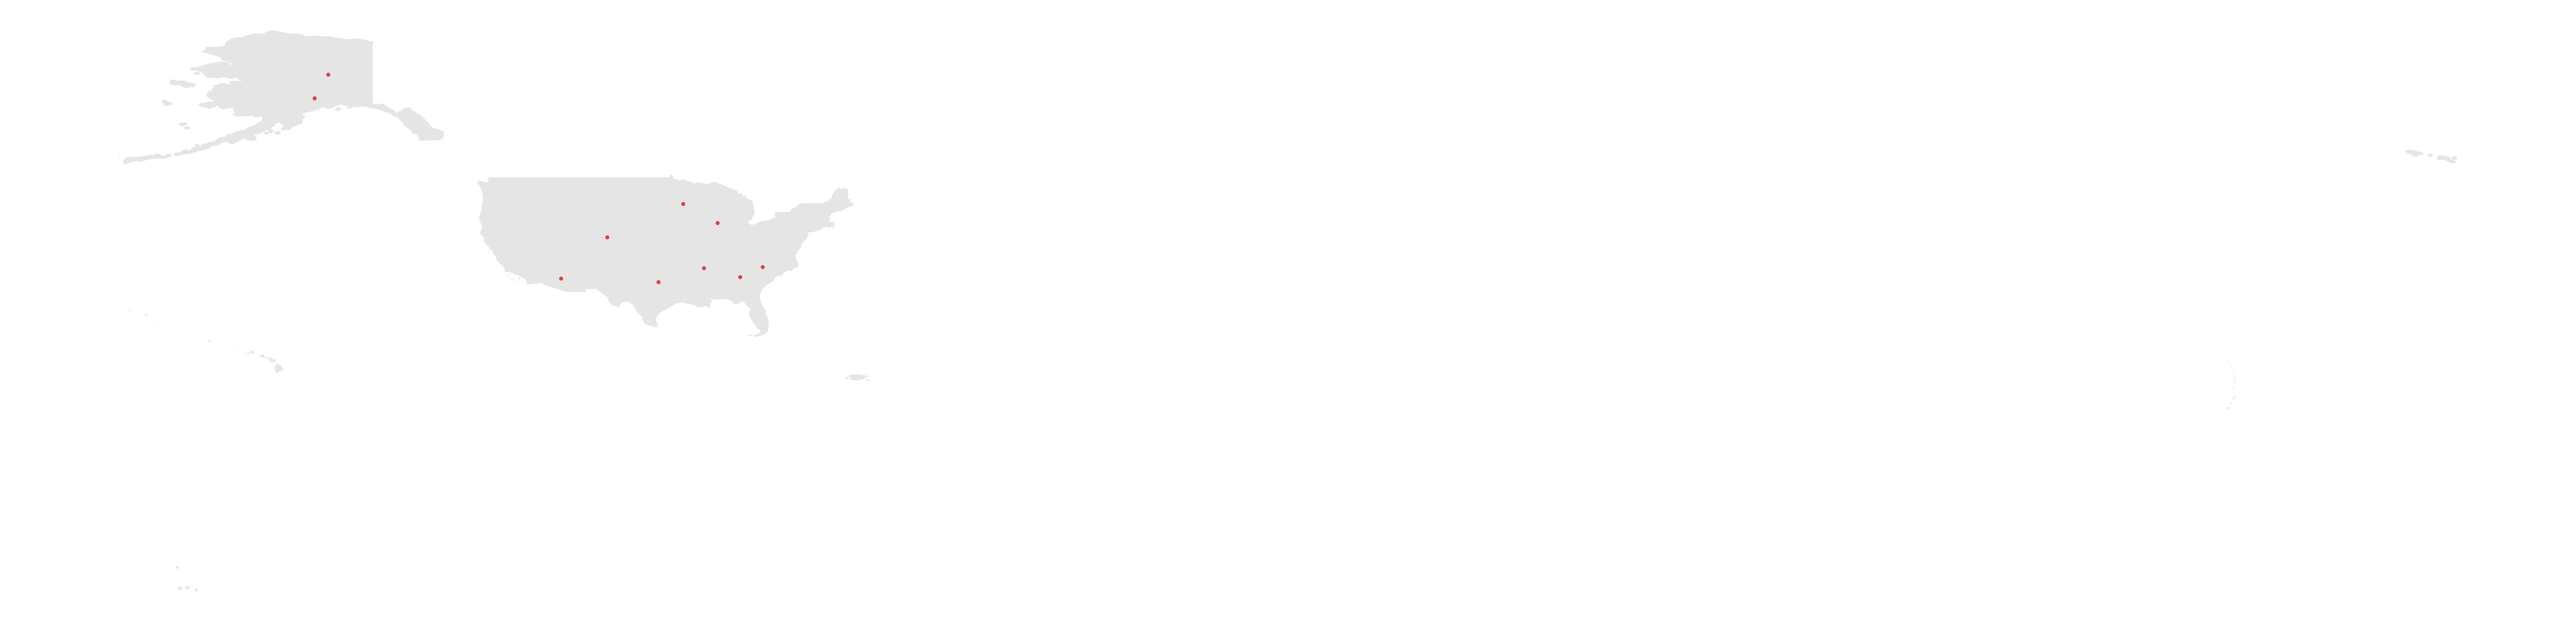

In [55]:
# Top 10 pagerank nodes visualization
labels=list(map(lambda x: x[0],pg_rank[:10]))
fig, ax = plt.subplots(1,1,figsize=(100,40))
base = shp_us.plot(ax=ax, color='gray', alpha=0.2)
geo_stations[geo_stations.station_ids.isin(labels)].plot(ax=base, marker="o", color="r", markersize=100,alpha=0.8, zorder=0)
_ = ax.axis('off')
fig.tight_layout()
fig.savefig("{}/figures/pagerank.pdf".format(dir_path))

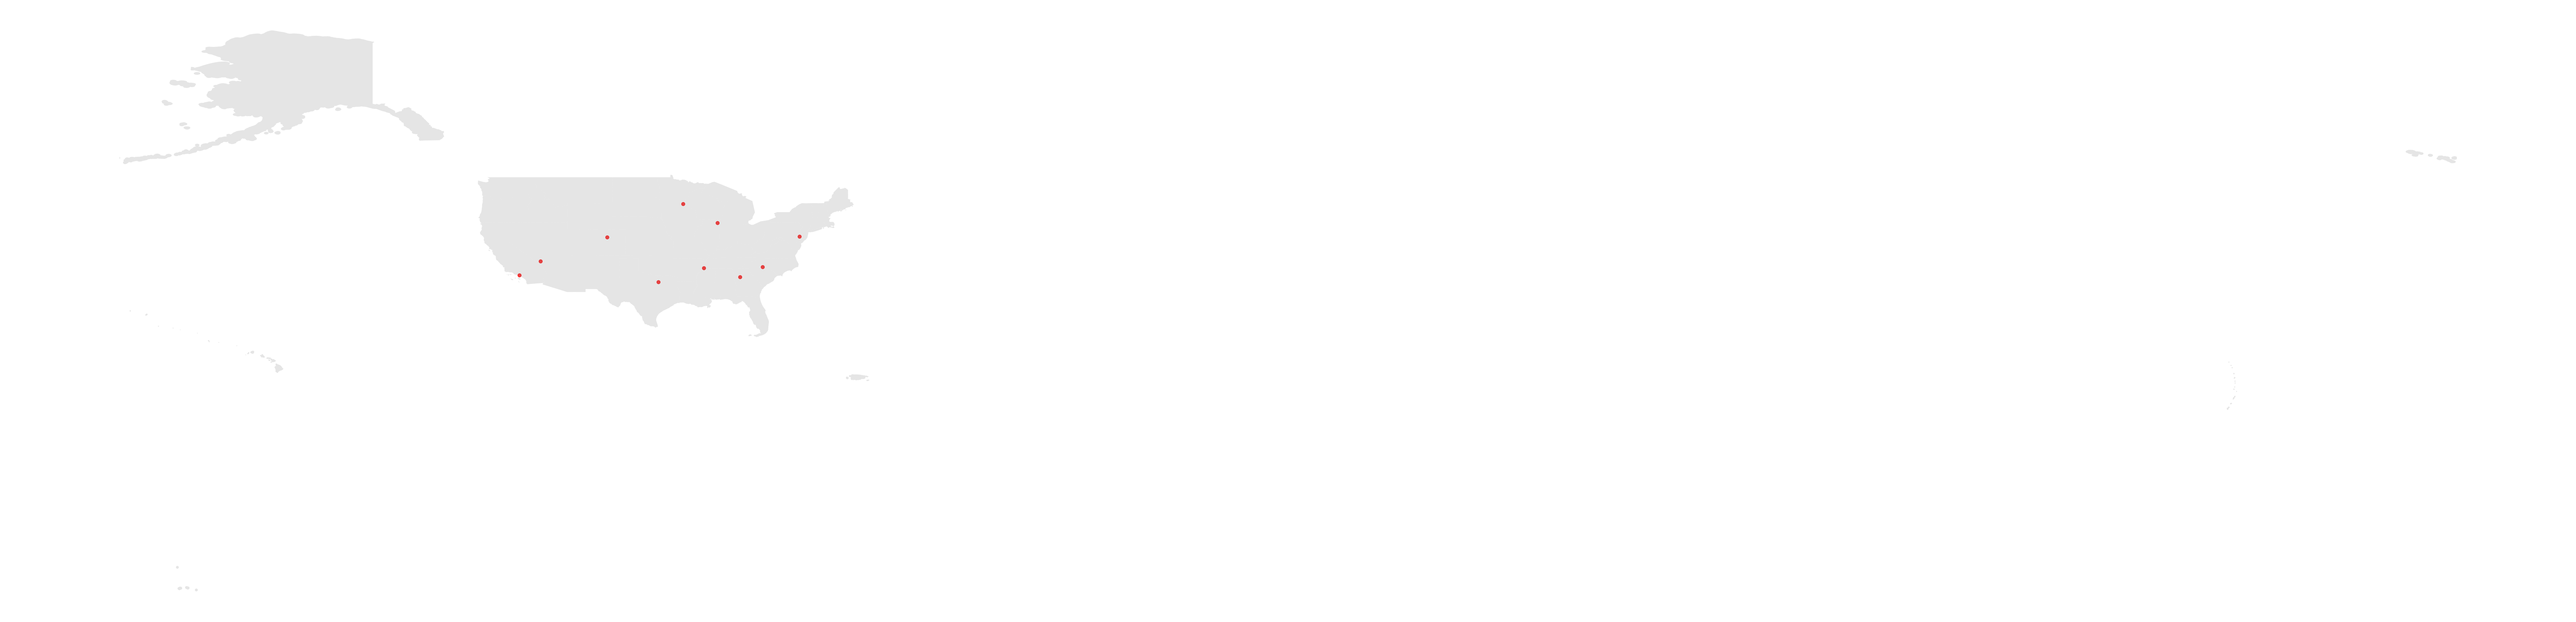

In [56]:
# Top 10 hubs nodes visualization
labels=list(map(lambda x: x[0],hubs[:10]))
fig, ax = plt.subplots(1,1,figsize=(100,40))
base = shp_us.plot(ax=ax, color='gray', alpha=0.2)
geo_stations[geo_stations.station_ids.isin(labels)].plot(ax=base, marker="o", color="r", markersize=100,alpha=0.8, zorder=0)
_ = ax.axis('off')
fig.tight_layout()
fig.savefig("{}/figures/hubs.pdf".format(dir_path))

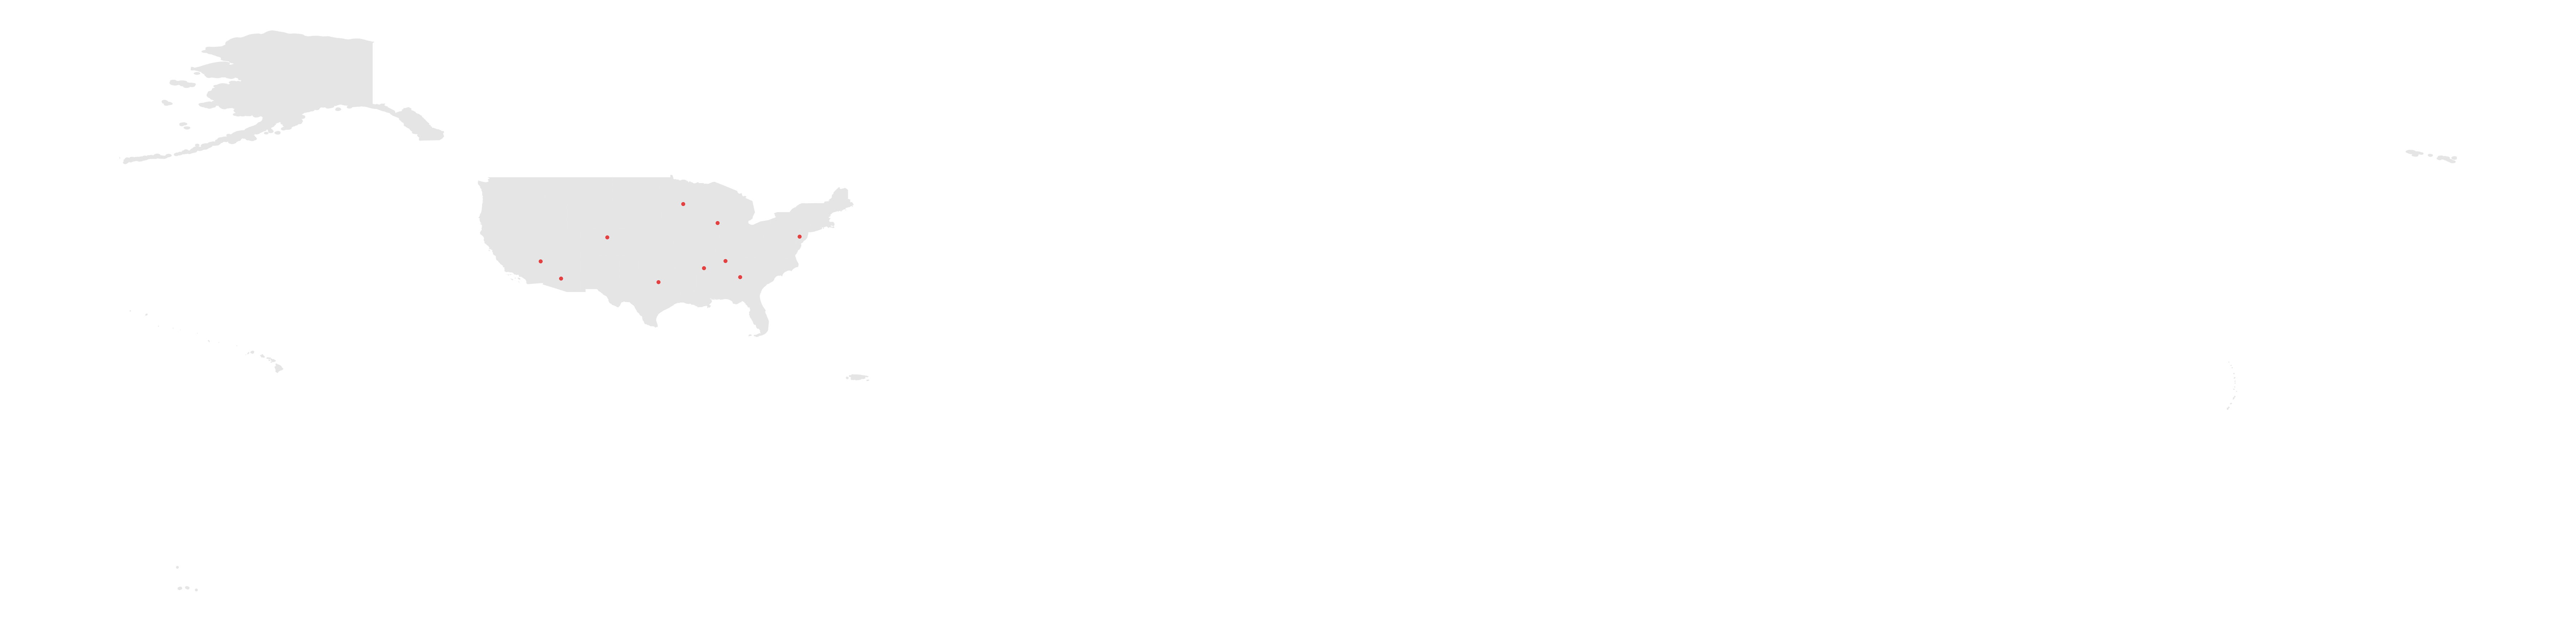

In [57]:
# Top 10 authorities nodes visualization
labels=list(map(lambda x: x[0],authorities[:10]))
fig, ax = plt.subplots(1,1,figsize=(100,40))
base = shp_us.plot(ax=ax, color='gray', alpha=0.2)
geo_stations[geo_stations.station_ids.isin(labels)].plot(ax=base, marker="o", color="r", markersize=100,alpha=0.8, zorder=0)
_ = ax.axis('off')
fig.tight_layout()
fig.savefig("{}/figures/authorities.pdf".format(dir_path))